In [14]:
import pandas as pd
import numpy as np

from sklearn.decomposition import NMF, LatentDirichletAllocation # DETECCIÓN DE TOPICOS:NMF LDA
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from wordcloud import WordCloud
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
provedores = pd.read_csv('contrataciones_por_proveedor.csv',sep=';')

In [3]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx+1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [4]:
def tokenizar(x):
    tokens = word_tokenize(x)
    stopw = [w.encode('utf-8') for w in stopwords.words('spanish')]
    stopw.extend([b'.', b'[', ']', b',', b';', b'', b')', b'),', b' ', b'(', b':', b'?', b'+', b'-' ])#, b'adquisicion'])
    stemmer = SnowballStemmer('spanish')
    stemmers = [stemmer.stem(token) for token in tokens]
    stems = [stem for stem in stemmers if stem.isalpha() and len(stem) > 1]
    final = [stemmed_word.lower()
     for stemmed_word in stems if stemmed_word.lower().encode('utf-8') not in stopw]
    
    return final

In [5]:
def obtenerFrecuenciaPalabras(matrizFreq, clusters_indexados):
    matrizFreq["categoria"] = clusters_indexados
    cluster_freq_grouped = matrizFreq.groupby(by=['categoria']).sum()
    cluster_freq_grouped_transpose = cluster_freq_grouped.transpose()
    return cluster_freq_grouped_transpose.to_dict() 

In [6]:
cv = CountVectorizer(tokenizer=tokenizar, strip_accents="unicode",max_df=0.8)
data_cv = cv.fit_transform(provedores["Objeto contractual"])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

In [8]:
pca = PCA(n_components=0.7, svd_solver ='full')
pca.fit(data_dtm)
data_pca = pca.transform(data_dtm)

In [9]:
data_pca.shape

(19618, 131)

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1c291a8e90>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

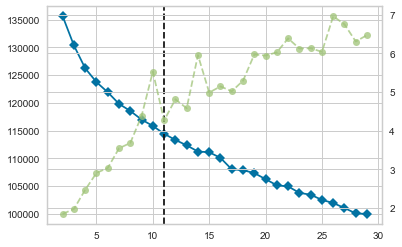

In [10]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30))
visualizer.fit(data_pca)


In [11]:
model = KMeans(11)
model.fit(data_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [12]:
data_cluster_pca = provedores.copy()
data_cluster_pca["categoria"] = model.predict(data_pca)
freq_dict_cluster_pca = obtenerFrecuenciaPalabras(data_dtm, data_cluster_pca["categoria"])

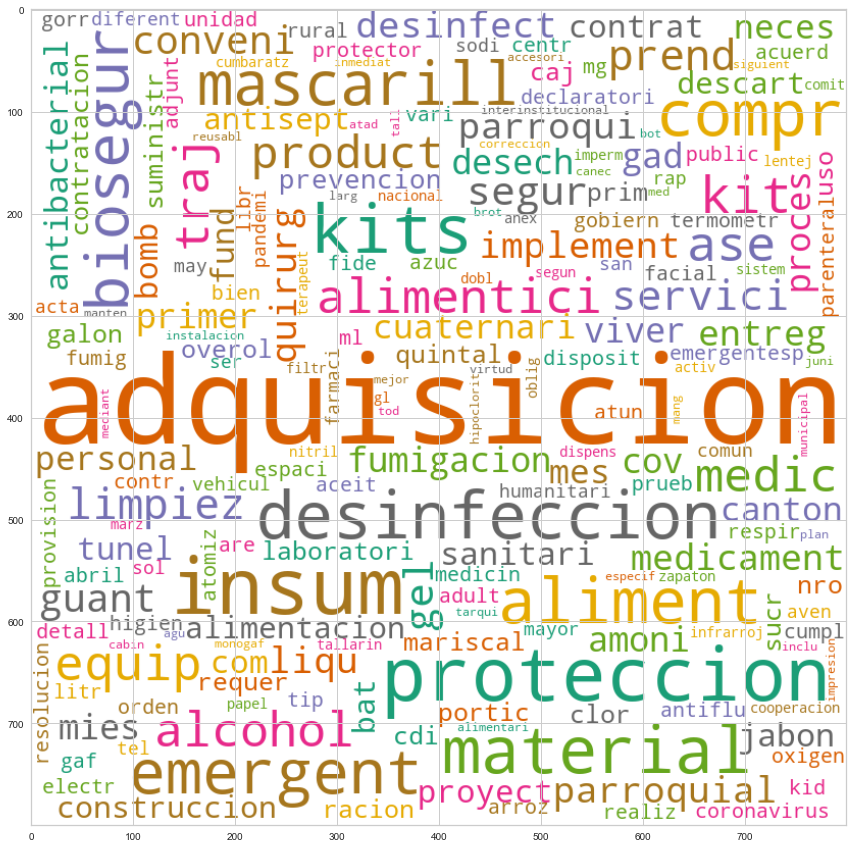

In [41]:
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150,width=800, height=800)

wc.generate_from_frequencies(freq_dict_cluster_pca[6])
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [19]:
provedores["categoria"] = data_cluster_pca["categoria"]

In [30]:
provedores.to_csv("contrataciones_por_proveedor_clustered.csv", sep=";")

In [42]:
provedores[provedores["categoria"] == 6]

,Proveedor,Entidad Contratante,Código de resolución,Código de contratación,Objeto contractual,Unidad de medida,Cantidad,Descripción compra por ítem,Precio unitario,Precio total,categoria
0,MARTINEZ VELASQUEZ ISIDORO RICARDO,MINISTERIO DE SALUD PUBLICA MATRIZ,00026-2020,00026-2020-00047,ADQUISICIÓN DE RESPIRADOR CON EFICIENCIA DE FI...,Unidad,2000000.00,RESPIRADOR CON EFICIENCIA DE FILTRACIÓN MÍNIMA...,4.98,9960000.00,6
6,CONSORCIO CEMENTERIO SUBURBIO,MUNICIPALIDAD DE GUAYAQUIL,CE-MIMG-003-2020,CE-MIMG-003-2020-00019,REPOTENCIACIÓN CEMENTERIO ANGEL MARÍA CANALS,Unidad,1.00,NaN,3348252.56,3348252.56,6
11,APOLO APOLO JOSE GONZALO,MINISTERIO DE SALUD PUBLICA MATRIZ,00026-2020,00026-2020-00030,ADQUISICIÓN DE PIPERACILINA + TAZOBACTAM SOLID...,Unidad,280800.00,PIPERACILINA + TAZOBACTAM SOLIDO PARENTERAL 40...,4.95,1389960.00,6
27,APOLO APOLO JOSE GONZALO,MINISTERIO DE SALUD PUBLICA MATRIZ,00026-2020,00026-2020-00023,ADQUISICIÓN DE AMOXICILINA + ÁCIDO CLAVULÁNICO...,Unidad,210600.00,AMOXICILINA + ACIDO CLAVULANICO SOLIDO PARENTE...,3.55,747630.00,6
29,TRENWELL SDRL,EMPRESA UNIVERSITARIA DE SALUD EP EUS EP,EUSEP-006-2020,EUSEP-006-2020-00001,ADQUISICIÓN DE MASCARILLAS CON CERTIFICACIÓN N...,Unidad,250000.00,MÁSCARA RESPIRATORIA KN95 EQUIVALENTE N95 4-PL...,2.80,700000.00,6
...,...,...,...,...,...,...,...,...,...,...,...
19612,COBO SALINAS MARCO ANTONIO,GOBIERNO AUTONOMO DESCENTRALIZADO MUNICIPAL DE...,026-2020-PSM-AL,026-2020-PSM-AL-00001,"NINGUNA, INFORME DE CREACIÓN DE ERROR DE EMERG...",Unidad,1.00,INGRESO DE DATOS PARA FINALIZACION DEL PROCESO,0.00,0.00,6
19614,CUMPLIMIENTO A LA CIRCULAR NRO. SERCOP-SERCOP-...,MUNICIPIO DE PEDERNALES,061-OEAN-GADMCP-2020,061-OEAN-GADMCP-2020-00001,CUMPLIMIENTO A LA CIRCULAR NRO. SERCOP-SERCOP-...,Unidad,0.01,SERVICIOS PRESTADOS POR OTRAS ENTIDADES EXTRAT...,0.00,0.00,6
19615,GOBIERNO AUTONOMO DESCENTRALIZADO MUNICIPAL DE...,GOBIERNO AUTONOMO DESCENTRALIZADO DEL CANTON R...,GADMR-ALC-2020-031-R,GADMR-ALC-2020-031-R-00001,INFORME DUPLICACION DE PUBLICACION DE SITUACIO...,Global,1.00,INFORME DUPLICACION DE PUBLICACION DE SITUACIO...,0.00,0.00,6
19616,ACLARATORIA,GOBIERNO AUTONOMO DESCENTRALIZADO MUNICIPAL DE...,GADMSD-RWEA-2020-153,GADMSD-RWEA-2020-153-00001,CUMPLIMIENTO A LA CIRCULAR NRO. SERCOP-SERCOP-...,Unidad,1.00,cumplimiento a la Circular Nro. SERCOP-SERCOP-...,0.00,0.00,6


## Grupos 

* **Grupo 0:** Kits alimenticios y productos de primera necesidad 
* **Grupo 1:** Medicamentos e insumos médicos a hospitales
* **Grupo 2:** Compra de mascarillas, guantes y elementos de protección de personal
* **Grupo 3:** Insumos médicos y de protección y desinfección (agrupados por la palabra emergencia, esto puede indicar que fueron compras hechas al inicio)
* **Grupo 4:** Kits alimenticios e insumos. Diferenciados del grupo 0 por nombres largos, parecidos y específicos.
* **Grupo 5:** Compra de prendas y accesorios de protección para personal no hospitalario
* **Grupo 6:** Compra insumos de protección, medicinas, bioseguridad. (Separados por nombres cortos y específicos. Ej. "ADQUISICION DE KIT DE PROTECCION")
